In [24]:
import numpy as np 
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt

In [25]:

# Adjust this path to where your images are located in the Kaggle environment
source_folder = "/kaggle/input/the-oxfordiiit-pet-dataset/images"
output_folder = "/kaggle/working/organized_images"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through and organize images
for filename in os.listdir(source_folder):
    if os.path.isfile(os.path.join(source_folder, filename)):
        # Split to get category name
        name_parts = filename.split("_")
        category = '_'.join(name_parts[:-1])  # Everything except the last part

        # Create category subfolder
        category_folder = os.path.join(output_folder, category)
        os.makedirs(category_folder, exist_ok=True)

        # Copy image to the new folder
        src_path = os.path.join(source_folder, filename)
        dst_path = os.path.join(category_folder, filename)
        shutil.copy(src_path, dst_path)

print("✅ Images organized successfully in:", output_folder)


✅ Images organized successfully in: /kaggle/working/organized_images


In [26]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [27]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/organized_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7390 files belonging to 37 classes.


In [28]:

class_names = dataset.class_names
class_names

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [29]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 7 33  6 19 31 35 25 29 26 12  4  9  2  1 10 35  4 16 33  2 36 26  2  5
  8  7 31 29 22 10  0 24]


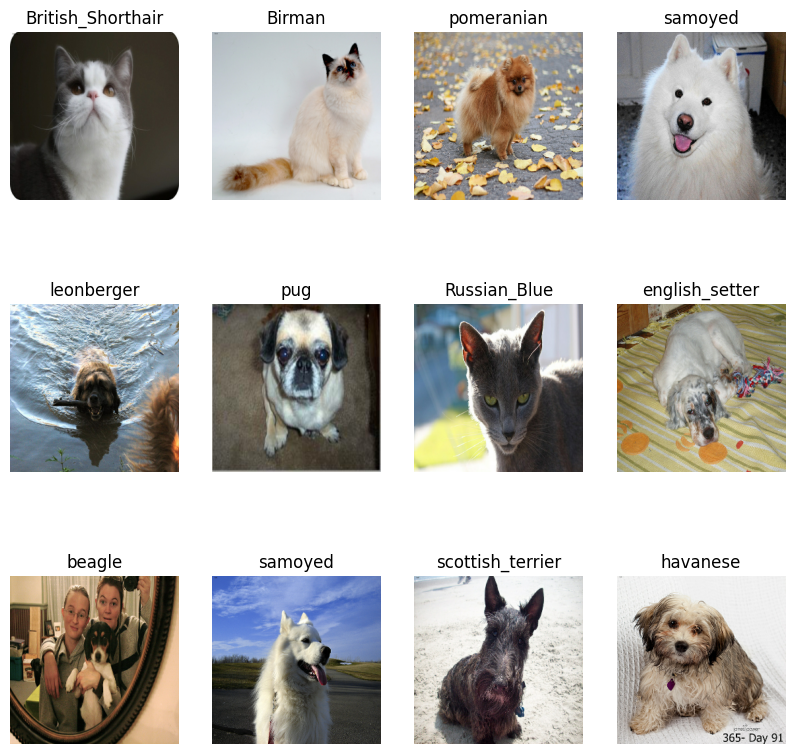

In [30]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [31]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [32]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [36]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
# from tensorflow.keras import layers
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# model = tf.keras.Sequential([
#     layers.InputLayer(input_shape=input_shape),
#     resize_and_rescale,
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(len(class_names), activation='softmax'),
# ])

In [38]:
import tensorflow as tf

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)

# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze the base

# Define the full model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    
    # Preprocessing
    resize_and_rescale,
    data_augmentation,
    
    # Base model
    base_model,
    tf.keras.layers.BatchNormalization(),

    # Global Pooling + Classifier Head
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Optional EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

<ipython-input-38-7bf0f324fcf7>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [39]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 37)                  │           9,509 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,573 (9.92 MB)

 Trainable params: 340,517 (1.30 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [40]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=300,
    callbacks = [early_stopping]
)

Epoch 1/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.0831 - loss: 4.3633 - val_accuracy: 0.6467 - val_loss: 1.8261
Epoch 2/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.3451 - loss: 2.3552 - val_accuracy: 0.7867 - val_loss: 0.8494
Epoch 3/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.4817 - loss: 1.7890 - val_accuracy: 0.8315 - val_loss: 0.6019
Epoch 4/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5580 - loss: 1.5172 - val_accuracy: 0.8628 - val_loss: 0.5029
Epoch 5/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6051 - loss: 1.3429 - val_accuracy: 0.8628 - val_loss: 0.4462
Epoch 6/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6546 - loss: 1.1681 - val_accuracy: 0.8818 - val_loss: 0.4036
Epoch 7/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6572 - loss: 1.1383 - val_accuracy: 0.8859 - val_loss: 0.3740
Epoch 8/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6723 - loss: 1

In [41]:
scores = model.evaluate(test_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9322 - loss: 0.1979


In [42]:
scores

[0.201776921749115, 0.9270833134651184]

In [43]:
history.params

{'verbose': 1, 'epochs': 300, 'steps': 184}

In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [45]:
len(history.history['accuracy'])

41

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


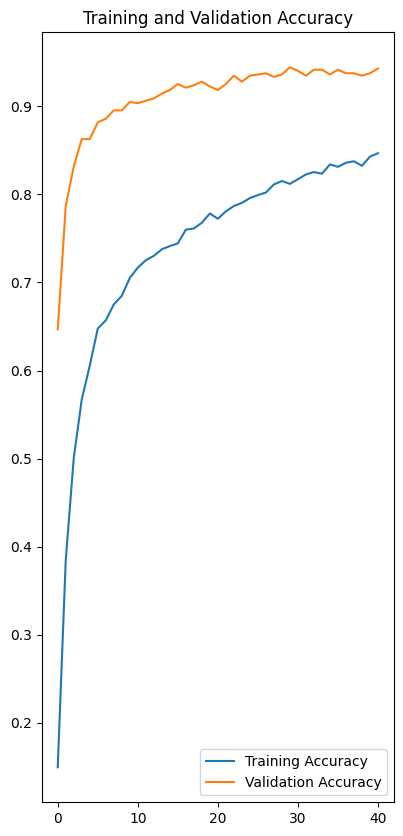

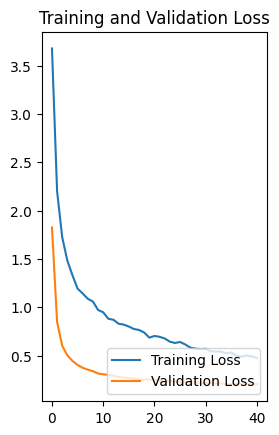

In [50]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(range(41), acc, label = "Training Accuracy")
plt.plot(range(41), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(1,2,2)
plt.plot(range(41), loss, label = "Training Loss")
plt.plot(range(41), val_loss, label = "Validation Loss")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Loss")
plt.show()

First Image to predict
actual label staffordshire_bull_terrier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
staffordshire_bull_terrier


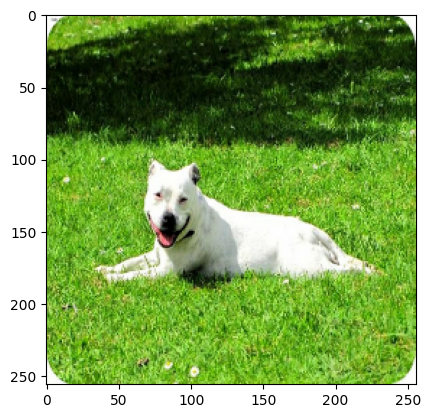

In [55]:
for images_batch, label_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('First Image to predict')
    plt.imshow(first_image)
    print('actual label', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])


In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create Batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


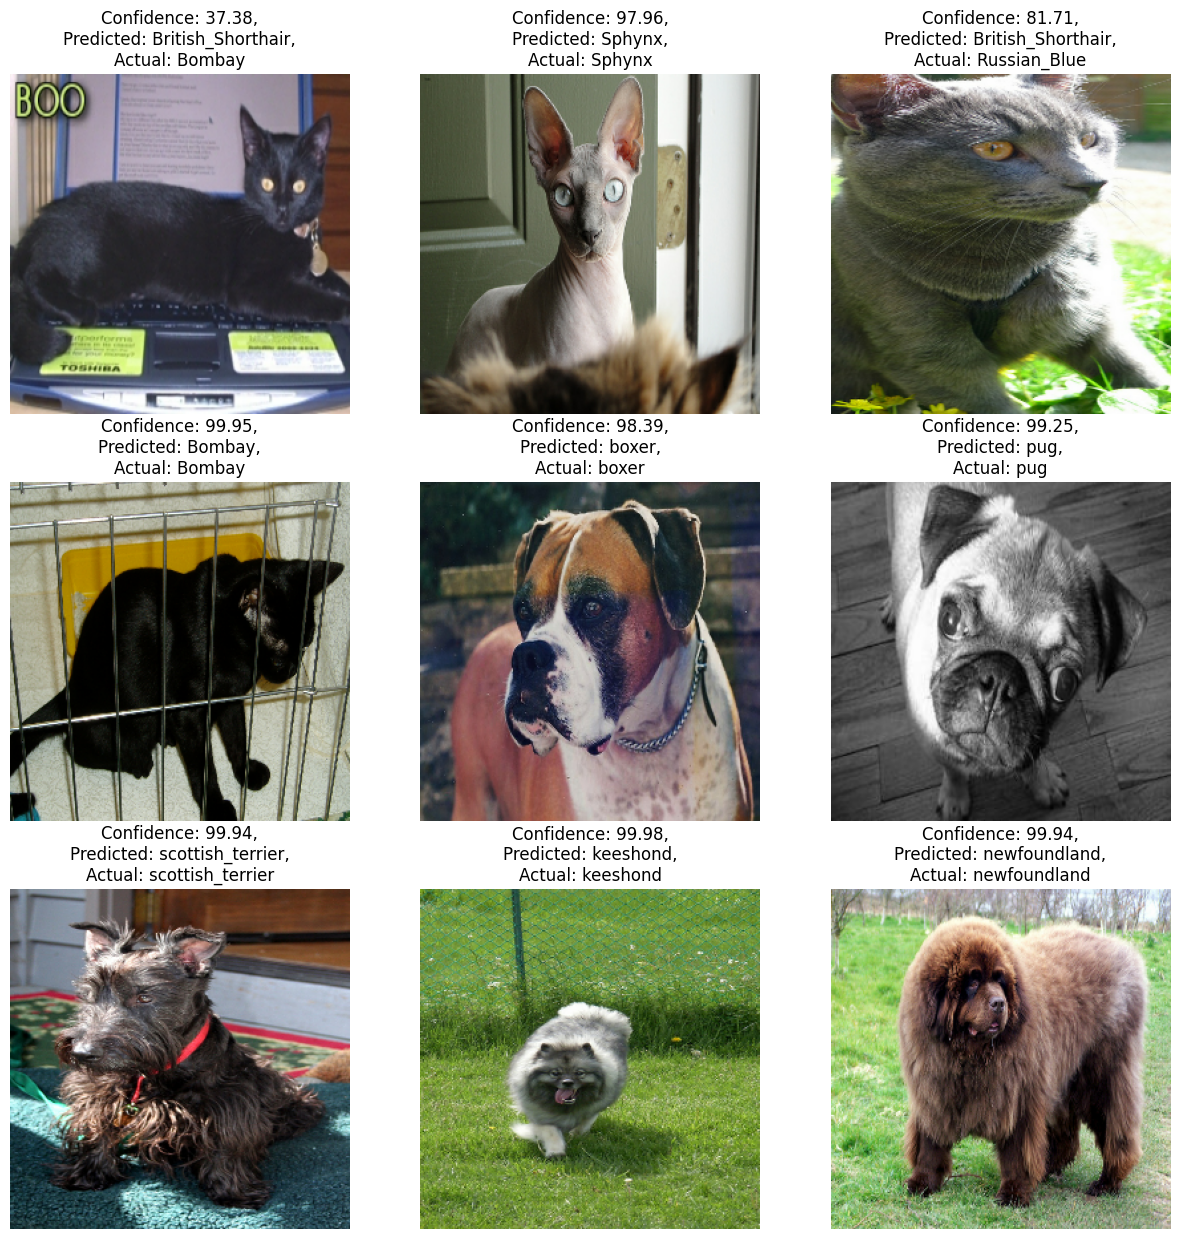

In [71]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3 , i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class , confidence = predict(model ,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Confidence: {confidence},\nPredicted: {predicted_class},\nActual: {actual_class}")
        plt.axis('off')

In [75]:
model_version = 1
model.export(f"models/{model_version}")


Saved artifact at 'models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_324')
Output Type:
  TensorSpec(shape=(None, 37), dtype=tf.float32, name=None)
Captures:
  134550671730368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550671732128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550663302128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550669771168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550669770816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550671736528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550669772224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550669779792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550669778736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550669781200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550669772048: 

In [76]:
shutil.make_archive("models", 'zip', "models")

'/kaggle/working/models.zip'